# MPModel: Infering the detergent corona around a membrane protein

Throughout this tutorial, we will buid a coarse-grained model of a micelle around the  membrane protein Human Glucose Transporter GLUT4 (PDB: 7WSN) and use the `simSPI` package to simulate a cryo-EM experiment of the structure. For that, it is necessary to have installed the python libraries: Matplotlib, Numpy, Gemmi, Mrcfile and Scipy.


<p align="center">
    <img src="figures/2b6p_map.png" alt="Drawing" style="width: 700px;"/>
    <p style="text-align: center">
        Figure 1: _Bos taurus_ Aquaporin-0 complex
    </p>
</p>

In [1]:
import os
import sys
import warnings

sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import math
import gemmi
import torch
import mrcfile
from matplotlib import pyplot as plt, axes as ax
import seaborn as sns
from scipy.spatial.transform import Rotation as rot

from simSPI.linear_simulator.linear_simulator import LinearSimulator
from test_linear_simulator import init_data

import detergent_belt as mpm
import atomic_models

In [27]:
root_dir = "/home/helena_alvarenga/comSPI_fork/simSPI"  #change this to your simSPI directory.
data_path = f"{root_dir}/tests/data/linear_simulator_data.npy"
project_name = "experiment_100_samples_4/" #change your project name
project_folder = f"{root_dir}/notebooks/outputs/{project_name}"

In [28]:
if os.path.exists(project_folder):
    print("File already exists!")
    pdb_folder = f"{project_folder}/pdb"
    mrc_folder = f"{project_folder}/mrc"
    proj_folder = f"{project_folder}/projections"
else:
    os.makedirs(project_folder)
    pdb_folder = os.makedirs(f"{project_folder}/pdb")
    mrc_folder = os.makedirs(f"{project_folder}/mrc")
    proj_folder = os.makedirs(f"{project_folder}/projections")
    pdb_folder = f"{project_folder}/pdb"
    mrc_folder = f"{project_folder}/mrc"
    proj_folder = f"{project_folder}/projections"

## Creating the model
<p style='text-align: justify;margin-right:10%;'>
Using Principal Component Analysis (PCA), a method for data decomposition, we can extract the main axis where our data is distributed. We can use a matrix transformation as a function to represent a modification on our dataset. In this case, the transformation is aligning the principal component of the coordinate points to the Z-axis. Therefore, we can distribute the atoms on another axis and, by doing so, rotate the protein so that its transmembrane portion is positioned properly in space.
</p>

To create the Ellipsoid we will compute the points that satisfy the condition: 
$\frac{x^{2}}{a^{2}} + \frac{y^{2}}{b^{2}} + \frac{z^{2}}{c^{2}} >= 1$

Consider $O = (0,0,0)$, as the protein was centered after the coordinates were imported.

<p align="center">
    <img src="figures/ellipsoid.png" alt="Drawing" style="width: 200px;"/>
    <p style="text-align: center">
        Figure 4: The geometric parameters of an ellipsoid
    </p>
</p>

The method used in this program creates an ellipsoid by generating points iteratively in regular intervals dependent on the ray of the pseudoatom. After that, a function removes the coordinates in the most inner part of the ellipsoid that would conflict with the protein's atoms. This process' speed depends on the number of pseudo atoms, that itself depends on the parameters of the corona such as the height, determined by size of the transmembrane portion of the protein, and on the ray of the pseudo atoms filling the ellipsoid.

In [24]:
def set_protein(path, ptn_axis):
    ptn = mpm.MembraneProtein(path)
    ptn.rotate_protein(ptn_axis)
    return ptn
        
def build_model(sample,ptn,path):
    micelle = mpm.DetergentBelt()
    micelle.set_belt_parameters(sample,40,25,7,[0,0,0]) #a1,a2,h,t,center set the parameters for the core of your micelle
    micelle.set_atomic_parameters(1.5, "C", "NH3")  #set the parameters for hydrophobic and hydrophilic pseudoatoms
    micelle.generate_core()
    micelle.generate_shell()
    
    micelle.in_hull(micelle.core_coordinates_set,ptn.final_coordinates)
    micelle.remove(micelle.core_coordinates_set)

    micelle.in_hull(micelle.shell_coordinates_set,micelle.core_coordinates_set)
    micelle.remove(micelle.shell_coordinates_set)
    micelle.in_hull(micelle.shell_coordinates_set,ptn.final_coordinates)      
    micelle.remove(micelle.shell_coordinates_set)
    
    file_name = f"{path}/{sample}.pdb"   #name your pdb file
    M = mpm.Model()
    M.clean_gemmi_structure()
    M.write_atomic_model(file_name, model=gemmi.Model("model"))
    M.create_model(file_name,micelle,ptn)

def run_sampling(runs,ptn,span,path):
    for i in range(runs):
        a = np.random.uniform(span[0],span[1])   #sample parameter a
        model = build_model(a,ptn,path)  #create model using sampled a

Let us create the corona with parameters chosen empirically for a better visualization of the exemple on Pymol.</br>

major axis &rarr; 50Å</br>
minor axis &rarr; 40Å</br>
height &rarr; 25Å</br>
shell thickness &rarr; 7Å</br>
center &rarr; [-2,-2,40]</br>
core pseudo atom &rarr; C</br>
shell pseudo atom &rarr; N</br>
pseudo atom ray &rarr; 1.5</br>

### Ground Truth Model

In [25]:
ptn = set_protein("7wsn.pdb", "Z")

In [11]:
build_model(50,ptn,pdb_folder)

### Sample Models

In [ ]:
runs = 200
span = [35,80]
run_sampling(runs,ptn,span,pdb_folder)

## Convert .pdb file to .mrc

We can do that in CHIMERAX using the following command:

molmap #[structure] [res]

XXXXXXXXXX
ADD IMAGE
MAYBE AUTOMIZE
XXXXXXXXXX

## Linear Simulation

In [5]:
def rotation(N):
    A = np.random.uniform(0,2*np.pi,N)
    V = np.random.uniform(0,1,3)
    R = []
    for a in A:
        r = rot.from_rotvec(a*V)
        R.append(r.as_matrix())
    return R #sampled rotations

In [6]:
def LinSim(vol_path, data_path, rotations):
    '''
    rotations -> list of rotation matrices
    '''
    with mrcfile.open(vol_path) as file:
        vol = file.data
    saved_data, config = init_data(data_path)
    
    #nx = vol.shape[0]
    #nx = 2*vol.shape[0]
    nx = 200
    config["input_volume_path"] = vol_path
    config["side_len"] = nx
    config["ctf_size"] = nx
    config["pixel_size"] = 1.2
    
    config["noise"] = True
    config["noise_sigma"] = 1    
    
    lin_sim = LinearSimulator(config)
    
    N = len(rotations)
    
    ctf_params = saved_data["ctf_params"]
    rot_params = {'rotmat': torch.Tensor(rotations)}
    shift_params = saved_data["shift_params"]
    shift_params["shift_x"] = torch.tensor([0.0,0.0,0.0,0.0])
    shift_params["shift_y"] = torch.tensor([0.0,0.0,0.0,0.0])
    particles = lin_sim(rot_params, ctf_params, shift_params)
    
    return particles #torch tensor for particle projection

## Parameter Inference

<p align="center">
    <img src="figures/parameters_new.png" alt="Drawing" style="width: 450px;"/>
    <p style="text-align: center">
        Figure 6: XXXXXXXXXXXXXXXXXXXXXXX ADD DESCRIPTION AND REFERENCE XXXXXXXXXXXXXXXXXXXX
    </p>
</p>

We will infer the parameter "a" by Rejection Approximation Bayesian Computation.

In [7]:
def pdb_to_mrc():
    pass

def run_projection(folder, data_path, R1, R2, R3, R4, R5):
    dataset = dict()
    for file in os.scandir(folder):
        filename = os.path.splitext(os.path.basename(file))[0]
        try:
            vol = file.path
        except:
            continue
        proj1 = LinSim(vol, data_path, R1)
        proj2 = LinSim(vol, data_path, R2)
        proj3 = LinSim(vol, data_path, R3)
        proj4 = LinSim(vol, data_path, R4)
        proj5 = LinSim(vol, data_path, R5)
    
        proj = torch.cat((proj1,proj2,proj3,proj4,proj5),0)
        torch.save(proj, proj_folder+f"/{filename}.npy")

def psnr(proj1, proj2):
    p1 = torch.max(proj1)
    p2 = torch.max(proj2)
    if p1 >= p2:
        p = p1
    else:
        p = p2
    se = []
    for i in range(len(proj1)):
        se.append(torch.sum((proj1[i]-proj2[i])**2))
    mse = np.mean(se)
    psnr = (10*(np.log10(p)**2))/mse
    return psnr

def rmsd(proj1, proj2):
    sd = []
    for i in range(len(proj1)):
        sd.append(torch.sum((proj1[i]-proj2[i])**2))
    return np.mean(np.sqrt(sd))
        
def run_inference(folder,gt):
    dataset = dict()
    for filename in os.scandir(folder):
        try:
            parameter = float(str(filename).strip("'<DirEntry .npy>'"))
        except:
            continue
        sim_proj = torch.load(filename.path)
        distance = psnr(gt_proj, sim_proj)
        dataset[parameter] = distance
    ordered = sorted(dataset.items())
    return ordered

def reject(rank,epsilon):
    save = list()
    e = epsilon
    for sample in rank:
        if sample[1] >= e:
            save.append((sample[0],float(sample[1])))
    return save

In [24]:
R1 = [[[ 0.1839408 , -0.35855848,  0.91520577],
       [ 0.46419033,  0.85241333,  0.24066335],
       [-0.86642549,  0.38056186,  0.32323297]],
       
       [[ 0.7806223 , -0.24775242,  0.57380098],
       [ 0.27614898,  0.96032491,  0.0389591 ],
       [-0.56068758,  0.12804221,  0.81806762]],
       
       [[-0.1475522 , -0.3389701 ,  0.92915425],
       [ 0.48751086,  0.79246187,  0.3665206 ],
       [-0.86055883,  0.50705371,  0.04832211]],
       
       [[-0.85591971,  0.32969827, -0.39837231],
       [-0.08946541,  0.66435155,  0.74204646],
       [ 0.5093107 ,  0.67077274, -0.539135  ]]]
       
R2 = [[[ 0.53679316, -0.30666962,  0.7860069 ],
       [ 0.83176915,  0.03614443, -0.55394373],
       [ 0.14146794,  0.9511295 ,  0.27448041]],
       
       [[ 0.59263101,  0.80096743,  0.08508622],
       [-0.33916667,  0.1523336 ,  0.92831053],
       [ 0.73058501, -0.57900401,  0.36193908]], 
       
       [[ 0.6352191 , -0.35745285,  0.68463432],
       [ 0.77097499,  0.24095226, -0.58952487],
       [ 0.04576316,  0.9023134 ,  0.42864469]],
       
       [[ 0.96869486, -0.19600425,  0.15235681],
       [ 0.23149231,  0.93485927, -0.26916436],
       [-0.08967482,  0.29600756,  0.95096685]]]
       
R3 = [[[ 0.85802171, -0.34406771,  0.38133471],
       [ 0.36523444,  0.93074178,  0.01798711],
       [-0.36111293,  0.12384323,  0.92426203]],
       
       [[-0.59572283, -0.42411887,  0.6820832 ],
       [ 0.6620161 ,  0.22159284,  0.71598275],
       [-0.45480655,  0.87807733,  0.14876561]],
       
       [[-0.77651325, -0.28404581,  0.56244569],
       [ 0.54889605,  0.13340174,  0.82517701],
       [-0.3094193 ,  0.9494851 ,  0.05232341]],
       
       [[-0.9293552 , -0.07103292,  0.36228888],
       [ 0.3586695 ,  0.05884413,  0.93160805],
       [-0.08749341,  0.99573676, -0.02920976]]]

R4 = [[[-0.1643302 ,  0.41784442,  0.89353323],
       [ 0.93996884, -0.20832921,  0.27029153],
       [ 0.29908888,  0.88431046, -0.35852595]],
       
       [[ 0.29106097, -0.10313157,  0.95112953],
       [ 0.92987885,  0.26427079, -0.25590287],
       [-0.22496409,  0.95891857,  0.17281878]],
       
       [[-0.24449334,  0.78249715,  0.57264406],
       [ 0.6688004 , -0.29152164,  0.68390143],
       [ 0.70208905,  0.55019392, -0.4520593 ]],
       
       [[ 0.77837569, -0.26922203,  0.56714265],
       [ 0.52767485,  0.7700007 , -0.35868952],
       [-0.34013312,  0.57846212,  0.74141152]]]

R5 = [[[-0.75294892,  0.54348553, -0.37106793],
       [ 0.37632785,  0.81817005,  0.43471268],
       [ 0.53985672,  0.18767324, -0.82056899]],
       
       [[ 0.27835729,  0.01949236,  0.96027979],
       [ 0.35917048,  0.92514542, -0.1228923 ],
       [-0.89079391,  0.37911212,  0.25051989]],
      
      [[ 0.14523074,  0.05048909,  0.98810874],
       [ 0.39802837,  0.91133646, -0.10506789],
       [-0.90580431,  0.4085544 ,  0.11225798]],
      
      [[-0.83779085,  0.43877559,  0.32493457],
       [ 0.52555633,  0.80936957,  0.26212869],
       [-0.14797648,  0.39038043, -0.90868371]]]

R = [R1,R2,R3,R4,R5]

In [8]:
R1 = rotation(4)
R2 = rotation(4)
R3 = rotation(4)
R4 = rotation(4)
R5 = rotation(4)
run_projection(mrc_folder, data_path, R1, R2, R3, R4, R5)

In [14]:
gt_model = f"{mrc_folder}/ground_truth.mrc" #name your ground-truth mrc file the same way

proj1 = LinSim(gt_model, data_path, R1)
proj2 = LinSim(gt_model, data_path, R2)
proj3 = LinSim(gt_model, data_path, R3)
proj4 = LinSim(gt_model, data_path, R4)
proj5 = LinSim(gt_model, data_path, R5)

proj = torch.cat((proj1,proj2,proj3,proj4,proj5),0)
torch.save(proj, proj_folder+"/ground_truth.npy")

In [52]:
sample = "86.464"
sim_model = f"{mrc_folder}/{sample}.mrc"

proj1 = LinSim(sim_model, data_path, R1)
proj2 = LinSim(sim_model, data_path, R2)
proj3 = LinSim(sim_model, data_path, R3)
proj4 = LinSim(sim_model, data_path, R4)
proj5 = LinSim(sim_model, data_path, R5)

proj = torch.cat((proj1,proj2,proj3,proj4,proj5),0)
torch.save(proj, f"{proj_folder}/{sample}.npy")

In [18]:
gt_proj = torch.load(f"{proj_folder}/ground_truth.npy")
epsilon = 0.0001
scores = run_inference(proj_folder,gt_proj)
accepted_samples = reject(scores,epsilon)

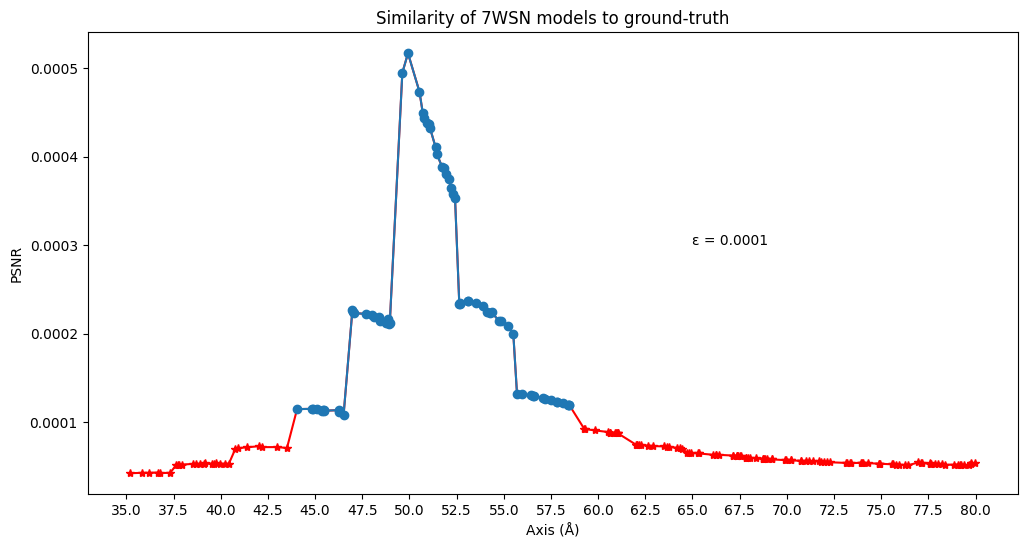

In [19]:
#visualize distribution
x1 = [i[0] for i in scores]
y1 = [i[1] for i in scores]
x2 = [i[0] for i in accepted_samples]
y2 = [i[1] for i in accepted_samples]

fig, ax = plt.subplots(figsize=(12,6))
plt.xticks(np.arange(35, 81, step=2.5))
plt.title("Similarity of 7WSN models to ground-truth")
plt.xlabel("Axis (Å)")
plt.ylabel("PSNR")
ax.text(65, 0.0003, f"ε = {epsilon}")

ax.plot(x1, y1, '-*', color = "red")
ax.plot(x2, y2, '-o')
plt.savefig(f"{project_folder}/plot_e{epsilon}.png")

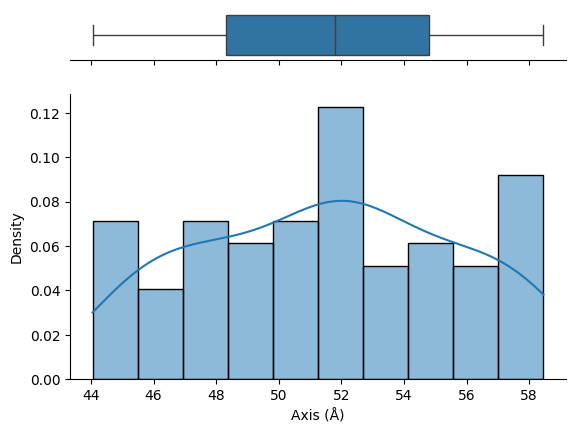

In [20]:
data = [i[0] for i in accepted_samples]

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x=data, ax=ax_box)
sns.histplot(x=data, bins=10, kde=True, stat='density', ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.xlabel("Axis (Å)")
plt.savefig(f"{project_folder}/hist_e{epsilon}.png")

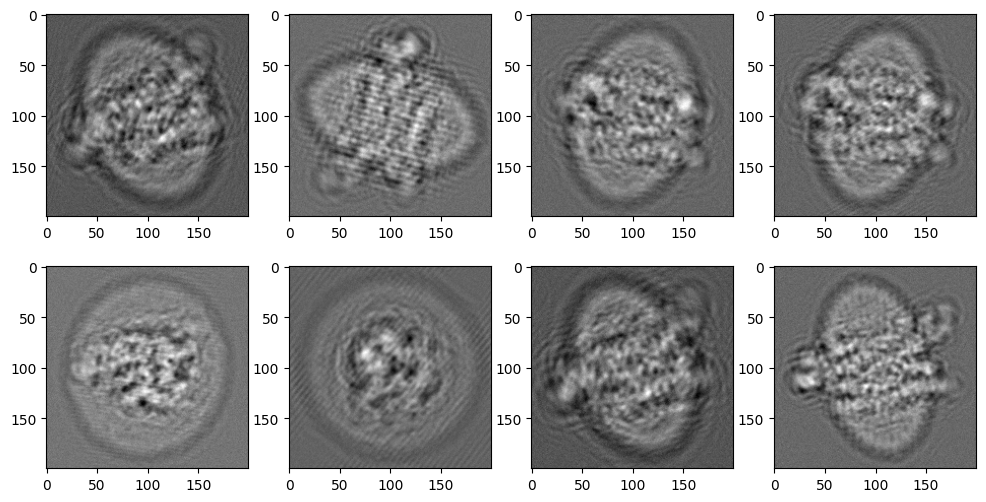

In [21]:
proj1 = torch.load(f"{proj_folder}/ground_truth.npy")
#proj2 = torch.load(f"{proj_folder}/42.020.npy")

f, ax = plt.subplots(2, 4, figsize=(12, 6))

ax[0,0].imshow(proj1[7, 0],cmap='gray')
ax[0,1].imshow(proj1[14, 0],cmap='gray')
ax[0,2].imshow(proj1[6, 0],cmap='gray')
ax[0,3].imshow(proj1[10, 0],cmap='gray')
ax[1,0].imshow(proj1[0, 0],cmap='gray')
ax[1,1].imshow(proj1[15, 0],cmap='gray')
ax[1,2].imshow(proj1[5, 0],cmap='gray')
ax[1,3].imshow(proj1[8, 0],cmap='gray')